In [2]:
import sys, os
sys.path.insert(0, 'workspace/')
sys.path.insert(1, 'model/LLaVA-Med/llava')

import torch
import json
from tqdm import tqdm
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import tokenizer_image_token, KeywordsStoppingCriteria, process_images

from PIL import Image
import math

import random
import numpy as np
import imagehash
import matplotlib.pyplot as plt

In [3]:
!nvidia-smi

Thu Oct 24 18:10:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA TITAN RTX               Off | 00000000:03:00.0 Off |                  N/A |
|100%   87C    P2             162W / 280W |  19407MiB / 24576MiB |     99%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
torch.cuda.set_device(1)
if torch.cuda.is_available():
    device = 'cuda'
    print(torch.cuda.current_device())

1


In [5]:
args_model_path = 'microsoft/llava-med-v1.5-mistral-7b'
args_guestion_file = 'data/eval/llava_med_eval_qa50_qa.jsonl'
args_conv_mode = 'mistral_instruct'
args_image_folder = 'data/images'
args_answers_file = 'answer-file_test.jsonl'

args_temperature = 0.0
args_num_chunks = 1
args_chunk_idx = 0
args_top_p = None
args_num_beams = 1

device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
def get_model_name_from_path(model_path):
    return model_path.split('/')[-1]

def set_seed(seed_value):
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
    np.random.seed(seed_value)

set_seed(0)

model_path = os.path.expanduser(args_model_path)
model_name = model_path.split('/')[-1]
print(f'Model name: {model_name.lower()}')

disable_torch_init()

# Load the model and processor
tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path, 
    None, 
    model_name, 
    load_8bit=False, 
    load_4bit=False, 
    device="cuda"
)
# model.eval()

Model name: llava-med-v1.5-mistral-7b


/opt/miniconda/envs/llava-med/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]
Some weights of the model checkpoint at microsoft/llava-med-v1.5-mistral-7b were not used when initializing LlavaMistralForCausalLM: ['model.vision_tower.vision_tower.vision_model.encoder.layers.17.self_attn.out_proj.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.23.layer_norm2.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.5.layer_norm2.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.12.layer_norm1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.18.self_attn.q_proj.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.9

### Get unique images

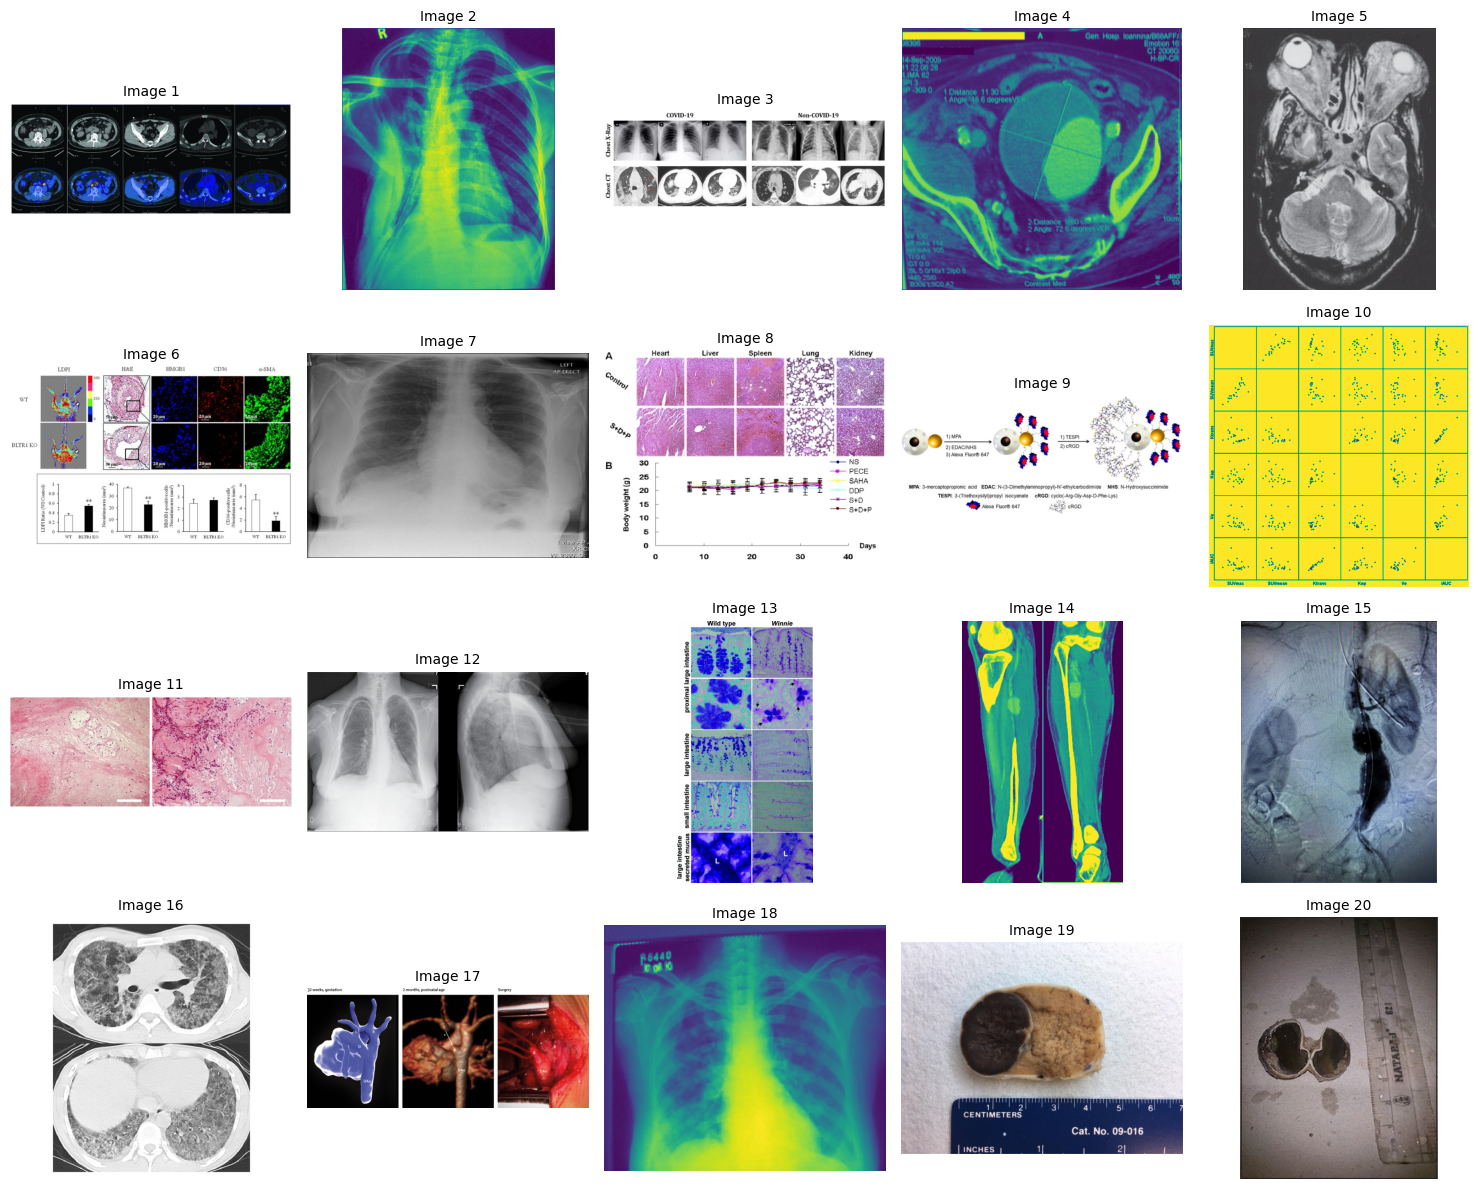

In [7]:

def get_unique_images(image_folder):
    image_hashes = set()
    unique_images = []
    for img_file in os.listdir(os.path.join('model/LLaVA-Med/', image_folder)):
        if img_file.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join('model/LLaVA-Med/', image_folder, img_file)
            
            with Image.open(img_path) as img:
                img_hash = imagehash.average_hash(img)

            if img_hash not in image_hashes:
                image_hashes.add(img_hash)
                unique_images.append(img_path)

    return unique_images

def show_unique_images(unique_image_paths, n=None, images_per_row=5):
    if n is None:
        n = len(unique_image_paths)  
    
    unique_image_paths = unique_image_paths[:n] 
    num_images = len(unique_image_paths)
    num_rows = (num_images + images_per_row - 1) // images_per_row  
    
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, num_rows * 3))
    
    for i, image_path in enumerate(unique_image_paths):
        img = Image.open(image_path)
        
        row = i // images_per_row
        col = i % images_per_row
        
        axes[row, col].imshow(img)
        axes[row, col].axis('off') 
        axes[row, col].set_title(f"Image {i+1}", fontsize=10)

    # hide empty subplots
    for i in range(num_images, num_rows * images_per_row):
        row = i // images_per_row
        col = i % images_per_row
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

unique_image_paths = get_unique_images(args_image_folder)
show_unique_images(unique_image_paths, n=20)

### Importance of correct input prompt

#### Default prompt

In [8]:
question = "Is there a pathology on the image?"

In [19]:
question

'Is there a pathology on the image?'

In [ ]:
prompt = f"{question}"
inputs = tokenizer(prompt, return_tensors='pt').to(device)
print(inputs['input_ids'])
tokenizer.batch_decode(inputs['input_ids'], skip_special_tokens=True)


tensor([[    1,  1691,   736,   264,  2439,  2161,   356,   272,  3469, 28804]],
       device='cuda:1')


['Is there a pathology on the image?']

torch.Size([1, 3, 336, 336])


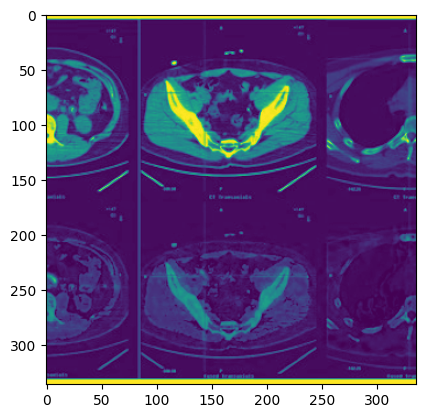

In [14]:
image = Image.open('model/LLaVA-Med/data/images/24926336_f2-etm-07-06-1521.jpg')

processed_image = image_processor(images=image, return_tensors='pt')['pixel_values']
image_tensor = processed_image.to(device)

# convert image tensor to Half if the model is in Half
if next(model.parameters()).dtype == torch.float16:
    image_tensor = image_tensor.half()  

print(image_tensor.shape)
# Move the channels to the last dimension
plt.imshow(image_tensor[0][0].detach().cpu())

In [17]:
model.eval()
with torch.no_grad():
    outputs = model(
                input_ids=inputs['input_ids'],
                images=image_tensor,
                output_hidden_states=True,  
                use_cache=False
            )

    # Last token's logits
    next_token_logits = outputs.logits[:, -1, :]
    next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)
    print(tokenizer.batch_decode(next_token, skip_special_tokens=True))

['\n']


#### Correct prompt

In [10]:
qs = question
if model.config.mm_use_im_start_end:
    qs = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + qs
else:
    qs = DEFAULT_IMAGE_TOKEN + '\n' + qs

# get prompt from template and question
conv = conv_templates[args_conv_mode].copy()
conv.append_message(conv.roles[0], qs)
conv.append_message(conv.roles[1], None)
prompt = conv.get_prompt()

# tokenize prompt
input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()
print(input_ids)
print(tokenizer.batch_decode(input_ids[0][6:], skip_special_tokens=True))

tensor([[    1,   733, 16289, 28793, 28705,  -200, 28705,    13,  2301,   736,
           264,  2439,  2161,   356,   272,  3469, 28804,   733, 28748, 16289,
         28793]], device='cuda:1')
['', '\n', 'Is', 'there', 'a', 'path', 'ology', 'on', 'the', 'image', '?', '[', '/', 'INST', ']']


torch.Size([3, 336, 336])


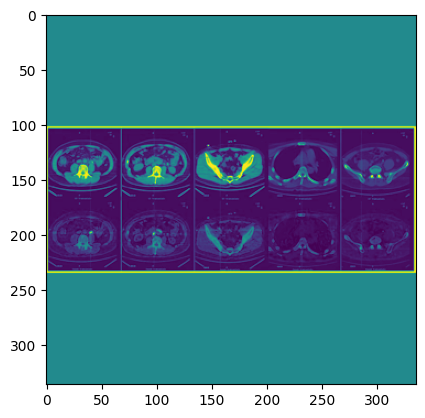

In [13]:
image = Image.open('model/LLaVA-Med/data/images/24926336_f2-etm-07-06-1521.jpg')
image_tensor1 = process_images([image], image_processor, model.config)[0]
print(image_tensor1.shape)
# Move the channels to the last dimension
plt.imshow(image_tensor1[0].detach().cpu())

In [18]:
model.eval()
with torch.no_grad():
    outputs = model(
                input_ids=input_ids,
                images=image_tensor1.unsqueeze(0).half().cuda(),
                output_hidden_states=True,  
                use_cache=False
            )

    # Last token's logits
    next_token_logits = outputs.logits[:, -1, :]
    next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)
    print(tokenizer.batch_decode(next_token, skip_special_tokens=True))

['Yes']


## How Contextual are Contextualized Word Representations?

In [9]:
def get_image_text_idxs(input_ids, tokenizer, emb_len, img_special_token=IMAGE_TOKEN_INDEX, img_tokens_len=576):
    # define service tokens len
    start_tokens_len = len(tokenizer('[INST]').input_ids)
    end_tokens_len = len(tokenizer('[/INST]').input_ids) - 1
    middle_tokens_len = len(tokenizer('\n').input_ids) - 1
    # get special image toekn position
    img_spec_token_pos = (input_ids[0] == IMAGE_TOKEN_INDEX).nonzero(as_tuple=True)[0]
    assert start_tokens_len == img_spec_token_pos - 1
    # define text tokens indexes in input prompt
    text_tokens_idxs = np.array(range(img_spec_token_pos + middle_tokens_len + 1, len(input_ids[0]))) #  - end_tokens_len
    print(tokenizer.convert_ids_to_tokens(input_ids[0][text_tokens_idxs]))
    # define image, text tokens indexes
    image_token_idxs = np.arange(start_tokens_len + 1, start_tokens_len + img_tokens_len + 1)
    text_tokens_idxs = text_tokens_idxs + img_tokens_len - 1

    return image_token_idxs, text_tokens_idxs

In [10]:
question = "Is there a pathology on the image?"

def get_unique_image_dataset(image_folder, question):
    image_hashes = set()
    unique_image_dataset = []

    for img_file in os.listdir(image_folder):
        if img_file.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(image_folder, img_file)
            
            with Image.open(img_path) as img:
                img_hash = imagehash.average_hash(img)

            if img_hash not in image_hashes:
                image_hashes.add(img_hash)
                unique_image_dataset.append({"image": img_path, "question": question})

    return unique_image_dataset

def generate_with_joint_embeddings(model, tokenizer, image_processor, image_file, question):

    # get question and image file name
    qs = question
    if model.config.mm_use_im_start_end:
        qs = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + qs
    else:
        qs = DEFAULT_IMAGE_TOKEN + '\n' + qs

    # get prompt from template and question
    conv = conv_templates[args_conv_mode].copy()
    conv.append_message(conv.roles[0], qs)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()

    # tokenize prompt
    input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()

    # load image
    image = Image.open(image_file)
    image_tensor = process_images([image], image_processor, model.config)[0]
    
    all_hidden_states = []  # store hidden states from all layers

    model.eval()
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            images=image_tensor.unsqueeze(0).half().cuda(),
            output_hidden_states=True,  
            use_cache=False
        )

        # Last token's logits
        next_token_logits = outputs.logits[:, -1, :]
        next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)
        output_text = tokenizer.batch_decode(next_token, skip_special_tokens=True)[0].strip()

        all_hidden_states = outputs.hidden_states
        
    torch.cuda.empty_cache()

    return input_ids, output_text, all_hidden_states

unique_image_dataset = get_unique_image_dataset(os.path.join('model/LLaVA-Med/', args_image_folder), question)
print(unique_image_dataset[0])

{'image': 'model/LLaVA-Med/data/images/24926336_f2-etm-07-06-1521.jpg', 'question': 'Is there a pathology on the image?'}


In [11]:
answers = []
layer2embs = {}
with torch.no_grad():
    for item in tqdm(unique_image_dataset, desc='Collecting embeddings'): ## Change if there is enough CUDA memory
        image_path = item['image']
        question = item['question']
        input_ids, output_text, all_hidden_states = generate_with_joint_embeddings(model, tokenizer, image_processor, image_path, question)
        # save answers
        answers.append({image_path: output_text})
        # save embeddings
        hidden_states = all_hidden_states
        img_emb_idxs, text_emb_idxs = get_image_text_idxs(input_ids, tokenizer, emb_len=hidden_states[0].shape[1])
        print(len(img_emb_idxs), len(text_emb_idxs))
        if len(img_emb_idxs) != 576:
            print(f"Something wrong with indexes for sample {j}.")

        # collect hidden states in dict by layers
        for i, emb in enumerate(hidden_states):
            if i in layer2embs:
                # layer2embs[i] += list(emb.cpu().detach()[0])
                layer2embs[i]['img'].append(emb.cpu().detach()[0][img_emb_idxs])
                layer2embs[i]['text'].append(emb.cpu().detach()[0][text_emb_idxs]) 
            else:
                # layer2embs[i] = list(emb.cpu().detach()[0])
                layer2embs[i] = { 
                                    'img': [emb.cpu().detach()[0][img_emb_idxs]], 
                                    'text': [emb.cpu().detach()[0][text_emb_idxs]] 
                                }

    # for i in range(len(hidden_states)):
    #     layer2embs[i]['img'] = torch.stack(layer2embs[i]['img'])
    #     layer2embs[i]['text'] = torch.stack(layer2embs[i]['text'])

['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


In [13]:
print(f'Number of layers: {len(layer2embs.keys())}')
print(f"Embs shape - img: {len(layer2embs[0]['img'])} text: {len(layer2embs[0]['text'])}")
print(f"Embs shape - img: {layer2embs[0]['img'][0].shape} text: {layer2embs[0]['text'][0].shape}")

Number of layers: 33
Embs shape - img: 50 text: 50
Embs shape - img: torch.Size([576, 4096]) text: torch.Size([13, 4096])


### Get embeddings from test questions for anisotropy

In [15]:
def split_list(lst, n):
    """Split a list into n (roughly) equal-sized chunks"""
    chunk_size = math.ceil(len(lst) / n)  # integer division
    return [lst[i:i+chunk_size] for i in range(0, len(lst), chunk_size)]


def get_chunk(lst, n, k):
    chunks = split_list(lst, n)
    return chunks[k]

In [16]:
questions = [json.loads(q) for q in open(os.path.join('model/LLaVA-Med/', args_guestion_file), "r")]
print(len(questions))
questions = get_chunk(questions, args_num_chunks, args_chunk_idx)

193


In [17]:
def generate_with_embeddings(model, tokenizer, line, max_new_tokens=1024):
    # get question and image file name
    image_file = line["image"]
    qs = line["text"].replace(DEFAULT_IMAGE_TOKEN, '').strip()
    if model.config.mm_use_im_start_end:
        qs = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + qs
    else:
        qs = DEFAULT_IMAGE_TOKEN + '\n' + qs

    # get prompt from template and question
    conv = conv_templates[args_conv_mode].copy()
    conv.append_message(conv.roles[0], qs)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()

    # tokenize prompt
    input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()

    # load image
    image = Image.open(os.path.join('model/LLaVA-Med', args_image_folder, image_file))
    image_tensor = process_images([image], image_processor, model.config)[0]

    # stopping criteria - is it used further?
    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)

    # Initial sequence of tokens
    inp_len = input_ids.shape[-1]
    generated_ids = input_ids
    all_hidden_states = [] # List for storing embeddings from every layer
    it = 0
    model.eval()
    with torch.no_grad():
        for _ in range(max_new_tokens):

                # Call forward model to get embeddings and logits
                outputs = model(
                    input_ids=generated_ids,
                    images=image_tensor.unsqueeze(0).half().cuda(),
                    output_hidden_states=True,  # Turn on hidden states return
                    use_cache=False,
                )
                for i, hidden_state in enumerate(outputs.hidden_states):
                    if torch.isnan(hidden_state).any():
                        print(f"NaN detected in layer {i}. Regenerating token...")

                all_hidden_states.append(outputs.hidden_states)
                # Last token's logits
                next_token_logits = outputs.logits[:, -1, :]
                next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)
                
                # Add predicted token to the sequence    
                generated_ids = torch.cat([generated_ids, next_token], dim=-1)
                # print(tokenizer.batch_decode(generated_ids[..., inp_len:], skip_special_tokens=True))
                
                torch.cuda.empty_cache()
                # Stop generation, if we got End Of Sequence (EOS) token
                if next_token.item() == tokenizer.eos_token_id:
                    break

    # Trasform predicted tokens back to the text
    model_output = generated_ids[..., inp_len:] # take model generated token
    output_text = tokenizer.batch_decode(model_output, skip_special_tokens=True)[0].strip()

    # Clean cache
    torch.cuda.empty_cache()

    return input_ids, image_tensor, output_text, all_hidden_states

In [18]:
def get_embeddings(model, tokenizer, questions, sample_number=64):
    if sample_number < len(questions):
        random.seed(42)
        idxs = random.sample(range(len(questions)), sample_number)
    else:
        idxs = range(len(questions))
    layer2embs = {}
    # sample_img_text_idxs = []
    with torch.no_grad():
        for j in tqdm(idxs, desc='Collecting embeddings'):
            # get question dict
            line = questions[j]
            # get input_ids, output and hidden_states
            input_ids, _, output_text, all_hidden_states = generate_with_embeddings(model, tokenizer, line, max_new_tokens=1)
            hidden_states = all_hidden_states[0]
            img_emb_idxs, text_emb_idxs = get_image_text_idxs(input_ids, tokenizer, emb_len=hidden_states[0].shape[1])
            print(len(img_emb_idxs), len(text_emb_idxs))
            if len(img_emb_idxs) != 576:
                print(f"Something wrong with indexes for sample {j}.")

            # sample_img_text_idxs.append((img_emb_idxs, text_emb_idxs))

            # collect hidden states in dict by layers
            for i, emb in enumerate(hidden_states):
                if i in layer2embs:
                    # layer2embs[i] += list(emb.cpu().detach()[0])
                    if j % 3 == 0: # иначе будет слишком много примеров
                        layer2embs[i]['img'].append(emb.cpu().detach()[0][img_emb_idxs])
                    layer2embs[i]['text'].append(emb.cpu().detach()[0][text_emb_idxs])
                else:
                    # layer2embs[i] = list(emb.cpu().detach()[0])
                    layer2embs[i] = { 
                                     'img': [emb.cpu().detach()[0][img_emb_idxs]], 
                                     'text': [emb.cpu().detach()[0][text_emb_idxs]]
                                    }

        # for i in range(len(hidden_states)):
        #     layer2embs[i]['img'] = torch.stack(layer2embs[i]['img'])
        #     layer2embs[i]['text'] = torch.stack(layer2embs[i]['text'])
            
        return layer2embs

In [19]:
with torch.no_grad():   
    torch.cuda.empty_cache()
    embs_dict = get_embeddings(model, tokenizer, questions, sample_number=193)

['What', '▁is', '▁the', '▁organ', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁type', '▁of', '▁cells', '▁are', '▁l', 'ining', '▁the', '▁c', 'yst', 'ic', '▁wall', '?', '▁[', '/', 'INST', ']']
576 17


['Are', '▁there', '▁any', '▁infl', 'am', 'mat', 'ory', '▁cells', '▁present', '?', '▁[', '/', 'INST', ']']
576 14


['What', '▁is', '▁the', '▁difference', '▁between', '▁the', '▁W', 'inn', 'ie', '▁and', '▁wild', '-', 'type', '▁m', 'ice', '?', '▁[', '/', 'INST', ']']
576 20


['What', '▁is', '▁the', '▁purpose', '▁of', '▁the', '▁st', 'aining', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁is', '▁the', '▁role', '▁of', '▁gob', 'let', '▁cells', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁is', '▁the', '▁difference', '▁between', '▁the', '▁images', '▁of', '▁the', '▁depressed', '▁patient', '▁and', '▁the', '▁healthy', '▁control', '▁subject', '?', '▁[', '/', 'INST', ']']
576 21


['What', '▁imag', 'ing', '▁technique', '▁was', '▁used', '?', '▁[', '/', 'INST', ']']
576 11


['What', '▁does', '▁hyp', 'o', 'front', 'ality', '▁indicate', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁is', '▁the', '▁yellow', '▁wave', 'form', '▁representing', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁does', '▁the', '▁time', '-', 'frequency', '▁plot', '▁illustr', 'ate', '?', '▁[', '/', 'INST', ']']
576 14


['What', '▁does', '▁the', '▁lower', '▁right', '▁panel', '▁show', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁does', '▁the', '▁chest', '▁X', '-', 'ray', '▁show', '?', '▁[', '/', 'INST', ']']
576 13


['Are', '▁there', '▁any', '▁signs', '▁of', '▁l', 'ym', 'ph', '▁node', '▁involvement', '?', '▁[', '/', 'INST', ']']
576 15


['What', '▁about', '▁met', 'ast', 'ases', '?', '▁[', '/', 'INST', ']']
576 10


['What', '▁organ', '▁is', '▁shown', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁is', '▁the', '▁main', '▁feature', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁type', '▁of', '▁tum', 'or', '▁is', '▁mentioned', '▁in', '▁the', '▁context', '?', '▁[', '/', 'INST', ']']
576 15


['What', '▁is', '▁the', '▁image', '▁showing', '?', '▁[', '/', 'INST', ']']
576 10


['How', '▁many', '▁inf', 'ants', '▁had', '▁a', '▁differential', '▁score', '▁of', '▁', '≥', '1', '▁for', '▁infl', 'amm', 'ation', '?', '▁[', '/', 'INST', ']']
576 21


['How', '▁many', '▁inf', 'ants', '▁had', '▁a', '▁differential', '▁score', '▁of', '▁', '≥', '2', '▁for', '▁fib', 'ros', 'is', '?', '▁[', '/', 'INST', ']']
576 21


['What', '▁is', '▁the', '▁main', '▁finding', '▁in', '▁the', '▁orb', 'ital', '▁M', 'RI', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁does', '▁pro', 'pt', 'osis', '▁mean', '?', '▁[', '/', 'INST', ']']
576 11


['What', '▁can', '▁you', '▁say', '▁about', '▁the', '▁extra', 'oc', 'ular', '▁muscles', '?', '▁[', '/', 'INST', ']']
576 15


['What', '▁is', '▁the', '▁main', '▁finding', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁type', '▁of', '▁scan', '▁is', '▁it', '?', '▁[', '/', 'INST', ']']
576 11


['Is', '▁the', '▁an', 'eur', 'ys', 'm', '▁in', '▁the', '▁a', 'ort', 'ic', '▁an', 'eur', 'ys', 'm', '▁or', '▁the', '▁left', '▁internal', '▁il', 'iac', '▁ar', 'tery', '?', '▁[', '/', 'INST', ']']
576 28


['What', '▁procedure', '▁was', '▁performed', '▁on', '▁the', '▁patient', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁was', '▁the', '▁purpose', '▁of', '▁the', '▁th', 'or', 'ac', 'op', 'last', 'y', '▁in', '▁this', '▁case', '?', '▁[', '/', 'INST', ']']
576 20


['What', '▁is', '▁the', '▁organ', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁are', '▁the', '▁ar', 'rows', '▁pointing', '▁to', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁does', '▁x', 'anth', 'og', 'ran', 'ul', 'om', 'at', 'ous', '▁mean', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁is', '▁the', '▁color', '▁of', '▁the', '▁mass', '?', '▁[', '/', 'INST', ']']
576 12


['Are', '▁there', '▁any', '▁areas', '▁of', '▁hem', 'orr', 'h', 'age', '▁or', '▁ne', 'c', 'ros', 'is', '?', '▁[', '/', 'INST', ']']
576 19


['What', '▁can', '▁you', '▁tell', '▁me', '▁about', '▁the', '▁vessels', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁are', '▁the', '▁major', '▁t', 'issues', '▁obtained', '▁from', '▁the', '▁m', 'ice', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁is', '▁the', '▁purpose', '▁of', '▁H', '&', 'E', '▁st', 'aining', '?', '▁[', '/', 'INST', ']']
576 15


['What', '▁is', '▁the', '▁significance', '▁of', '▁the', '▁mean', '▁body', '▁weights', '▁in', '▁the', '▁study', '?', '▁[', '/', 'INST', ']']
576 17


['What', '▁is', '▁the', '▁main', '▁focus', '▁of', '▁the', '▁figure', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁is', '▁the', '▁method', '▁used', '▁to', '▁determine', '▁H', 'ER', '2', '▁gene', '▁ampl', 'ification', '?', '▁[', '/', 'INST', ']']
576 18


['What', '▁is', '▁the', '▁significance', '▁of', '▁the', '▁C', 'ox', '▁reg', 'ression', '▁analysis', '▁model', '▁in', '▁this', '▁context', '?', '▁[', '/', 'INST', ']']
576 20


['What', '▁does', '▁the', '▁chest', '▁X', '-', 'ray', '▁show', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁is', '▁the', '▁condition', '▁of', '▁the', '▁heart', '?', '▁[', '/', 'INST', ']']
576 12


['Is', '▁there', '▁any', '▁other', '▁condition', '▁mentioned', '▁in', '▁the', '▁context', '?', '▁[', '/', 'INST', ']']
576 14


['What', '▁do', '▁the', '▁op', 'ac', 'ities', '▁look', '▁like', '?', '▁[', '/', 'INST', ']']
576 13


['Are', '▁the', '▁op', 'ac', 'ities', '▁present', '▁in', '▁both', '▁lungs', '?', '▁[', '/', 'INST', ']']
576 14


['What', '▁could', '▁be', '▁the', '▁possible', '▁cause', '▁of', '▁these', '▁op', 'ac', 'ities', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁is', '▁being', '▁comp', 'ressed', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁is', '▁causing', '▁the', '▁compression', '?', '▁[', '/', 'INST', ']']
576 10


['What', '▁type', '▁of', '▁M', 'RI', '▁is', '▁used', '▁in', '▁this', '▁image', '?', '▁[', '/', 'INST', ']']
576 15


['What', '▁type', '▁of', '▁fract', 'ure', '▁is', '▁shown', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 15


['Which', '▁ver', 'te', 'bra', 'e', '▁are', '▁affected', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁are', '▁the', '▁ar', 'rows', '▁pointing', '▁to', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁is', '▁the', '▁scatter', '▁matrix', '▁showing', '?', '▁[', '/', 'INST', ']']
576 11


['What', '▁are', '▁P', 'ET', '/', 'CT', '▁and', '▁D', 'CE', '-', 'M', 'RI', '?', '▁[', '/', 'INST', ']']
576 17


['What', '▁is', '▁the', '▁significance', '▁of', '▁the', '▁correl', 'ations', '▁in', '▁the', '▁scatter', '▁matrix', '?', '▁[', '/', 'INST', ']']
576 17


['What', '▁is', '▁the', '▁main', '▁finding', '▁in', '▁the', '▁left', '-', 'middle', '▁u', 're', 'ter', '?', '▁[', '/', 'INST', ']']
576 18


['What', '▁other', '▁findings', '▁are', '▁mentioned', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁imag', 'ing', '▁technique', '▁was', '▁used', '?', '▁[', '/', 'INST', ']']
576 11


['What', '▁organ', '▁is', '▁shown', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁is', '▁the', '▁color', '▁of', '▁the', '▁spl', 'en', 'ic', '▁tissue', '?', '▁[', '/', 'INST', ']']
576 15


['Is', '▁the', '▁spl', 'en', 'ic', '▁tissue', '▁separate', '▁from', '▁the', '▁test', 'icular', '▁tissue', '?', '▁[', '/', 'INST', ']']
576 17


['What', '▁type', '▁of', '▁tissue', '▁is', '▁shown', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 14


['What', '▁is', '▁the', '▁st', 'aining', '▁technique', '▁used', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁are', '▁the', '▁findings', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁are', '▁the', '▁main', '▁findings', '▁in', '▁the', '▁liver', '▁bi', 'ops', 'y', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁does', '▁con', 'fl', 'uent', '▁ne', 'c', 'ros', 'is', '▁mean', '?', '▁[', '/', 'INST', ']']
576 15


['What', '▁is', '▁b', 'iliary', '▁st', 'asis', '?', '▁[', '/', 'INST', ']']
576 11


['What', '▁is', '▁the', '▁organ', '▁shown', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁is', '▁the', '▁condition', '▁of', '▁the', '▁liver', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁disease', '▁is', '▁associated', '▁with', '▁this', '▁liver', '▁condition', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁is', '▁the', '▁blue', '▁arrow', '▁pointing', '▁to', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁is', '▁the', '▁red', '▁arrow', '▁pointing', '▁to', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁is', '▁the', '▁white', '▁arrow', '▁pointing', '▁to', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁is', '▁the', '▁size', '▁of', '▁the', '▁eyeb', 'all', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁is', '▁the', '▁color', '▁of', '▁the', '▁growth', '▁on', '▁the', '▁s', 'cl', 'eral', '▁surface', '?', '▁[', '/', 'INST', ']']
576 18


['Is', '▁the', '▁posterior', '▁half', '▁of', '▁the', '▁eyeb', 'all', '▁and', '▁opt', 'ic', '▁nerve', '▁involved', '?', '▁[', '/', 'INST', ']']
576 18


['What', '▁ar', 'tery', '▁is', '▁shown', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁does', '▁the', '▁image', '▁reveal', '▁about', '▁the', '▁v', 'ascular', 'ity', '▁of', '▁the', '▁ar', 'tery', '?', '▁[', '/', 'INST', ']']
576 19


['What', '▁is', '▁the', '▁significance', '▁of', '▁the', '▁normal', '▁v', 'ascular', 'ity', '?', '▁[', '/', 'INST', ']']
576 15


['What', '▁types', '▁of', '▁cells', '▁are', '▁present', '▁in', '▁the', '▁portal', '▁tr', 'acts', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁type', '▁of', '▁cells', '▁are', '▁shown', '▁in', '▁the', '▁H', '&', 'E', '▁image', '?', '▁[', '/', 'INST', ']']
576 17


['What', '▁mark', 'ers', '▁are', '▁the', '▁Reed', '-', 'S', 'tern', 'berg', '▁cells', '▁positive', '▁for', '?', '▁[', '/', 'INST', ']']
576 18


['What', '▁do', '▁the', '▁Dop', 'pler', '▁images', '▁show', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁is', '▁the', '▁purpose', '▁of', '▁the', '▁H', '&', 'E', '▁st', 'aining', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁do', '▁the', '▁anti', '-', 'H', 'M', 'GB', '1', '▁and', '▁anti', '-', 'CD', '3', '6', '▁antib', 'od', 'ies', '▁indicate', '?', '▁[', '/', 'INST', ']']
576 24


['What', '▁is', '▁the', '▁size', '▁of', '▁the', '▁mass', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁does', '▁the', '▁arrow', '▁point', '▁to', '?', '▁[', '/', 'INST', ']']
576 11


['How', '▁does', '▁the', '▁ser', 'os', 'al', '▁surface', '▁appear', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁do', '▁the', '▁black', '▁ar', 'rows', '▁indicate', '▁in', '▁the', '▁left', '▁image', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁does', '▁the', '▁green', '▁arrow', '▁point', '▁to', '▁in', '▁the', '▁left', '▁image', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁do', '▁the', '▁black', '▁ar', 'rows', '▁indicate', '▁in', '▁the', '▁right', '▁image', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁type', '▁of', '▁imag', 'ing', '▁is', '▁shown', '▁on', '▁the', '▁left', '▁side', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁type', '▁of', '▁imag', 'ing', '▁is', '▁shown', '▁on', '▁the', '▁right', '▁side', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁is', '▁the', '▁green', '▁cross', '▁indicating', '?', '▁[', '/', 'INST', ']']
576 11


['What', '▁does', '▁the', '▁chest', '▁X', '-', 'ray', '▁show', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁could', '▁be', '▁the', '▁cause', '▁of', '▁this', '▁consolid', 'ation', '?', '▁[', '/', 'INST', ']']
576 14


['What', '▁is', '▁the', '▁age', '▁of', '▁the', '▁patient', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁are', '▁the', '▁white', '▁ar', 'rows', '▁pointing', '▁to', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁is', '▁the', '▁diagnosis', '?', '▁[', '/', 'INST', ']']
576 9


['What', '▁is', '▁the', '▁main', '▁focus', '▁of', '▁the', '▁M', 'RI', '▁image', '?', '▁[', '/', 'INST', ']']
576 15


['What', '▁is', '▁the', '▁significance', '▁of', '▁the', '▁aster', 'isk', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁is', '▁the', '▁di', 'vert', 'ic', 'ulum', '▁of', '▁Kom', 'mer', 'ell', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁type', '▁of', '▁an', 'eur', 'ys', 'm', '▁is', '▁shown', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 17


['Where', '▁is', '▁the', '▁an', 'eur', 'ys', 'm', '▁located', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁imag', 'ing', '▁technique', '▁was', '▁used', '?', '▁[', '/', 'INST', ']']
576 11


['What', '▁does', '▁the', '▁chest', '▁CT', '▁show', '?', '▁[', '/', 'INST', ']']
576 11


['What', '▁is', '▁ground', '-', 'glass', '▁opacity', '?', '▁[', '/', 'INST', ']']
576 11


['What', '▁could', '▁be', '▁the', '▁possible', '▁causes', '▁of', '▁bil', 'ateral', '▁air', 'space', '▁consolid', 'ation', '?', '▁[', '/', 'INST', ']']
576 18


['Is', '▁there', '▁any', '▁ple', 'ural', '▁eff', 'usion', '▁visible', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁medical', '▁device', '▁is', '▁in', '▁place', '?', '▁[', '/', 'INST', ']']
576 11


['What', '▁is', '▁the', '▁purpose', '▁of', '▁the', '▁perm', '▁cat', 'he', 'ter', '?', '▁[', '/', 'INST', ']']
576 15


['What', '▁is', '▁the', '▁main', '▁finding', '▁in', '▁the', '▁chest', '▁X', '-', 'ray', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁does', '▁consolid', 'ation', '▁mean', '▁in', '▁this', '▁context', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁could', '▁be', '▁the', '▁possible', '▁cause', '▁of', '▁these', '▁consolid', 'ations', '?', '▁[', '/', 'INST', ']']
576 15


['What', '▁is', '▁the', '▁purpose', '▁of', '▁the', '▁path', 'way', '▁shown', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 17


['What', '▁are', '▁some', '▁of', '▁the', '▁tests', '▁and', '▁procedures', '▁included', '▁in', '▁the', '▁path', 'way', '?', '▁[', '/', 'INST', ']']
576 18


['What', '▁is', '▁the', '▁main', '▁focus', '▁of', '▁the', '▁path', 'way', '▁in', '▁relation', '▁to', '▁COVID', '-', '1', '9', '▁patients', '?', '▁[', '/', 'INST', ']']
576 22


['Can', '▁you', '▁describe', '▁the', '▁appearance', '▁of', '▁the', '▁gross', '▁spec', 'imen', '?', '▁[', '/', 'INST', ']']
576 15


['What', '▁type', '▁of', '▁imag', 'ing', '▁technique', '▁is', '▁used', '▁in', '▁this', '▁figure', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁does', '▁the', '▁image', '▁show', '?', '▁[', '/', 'INST', ']']
576 10


['What', '▁was', '▁the', '▁purpose', '▁of', '▁this', '▁imag', 'ing', '▁technique', '?', '▁[', '/', 'INST', ']']
576 14


['What', '▁is', '▁the', '▁purpose', '▁of', '▁the', '▁multi', '-', 'modal', '▁Jan', 'us', '▁nan', 'op', 'art', 'ic', 'ulate', '▁system', '?', '▁[', '/', 'INST', ']']
576 22


['What', '▁is', '▁the', '▁purpose', '▁of', '▁Sir', 'ius', '▁Red', '▁st', 'aining', '?', '▁[', '/', 'INST', ']']
576 15


['What', '▁is', '▁the', '▁scale', '▁bar', '▁in', '▁the', '▁micro', 'ph', 'ot', 'ograph', 's', '?', '▁[', '/', 'INST', ']']
576 17


['What', '▁is', '▁the', '▁main', '▁finding', '▁in', '▁the', '▁left', '▁vent', 'ric', 'les', '▁of', '▁the', '▁treated', '▁r', 'ats', '?', '▁[', '/', 'INST', ']']
576 21


['What', '▁does', '▁the', '▁white', '▁arrow', '▁indicate', '?', '▁[', '/', 'INST', ']']
576 11


['What', '▁does', '▁medi', 'ast', 'inal', '▁wid', 'ening', '▁mean', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁is', '▁the', '▁origin', '▁of', '▁the', '▁mass', '?', '▁[', '/', 'INST', ']']
576 12


['Does', '▁the', '▁mass', '▁involve', '▁the', '▁med', 'ull', 'a', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁type', '▁of', '▁imag', 'ing', '▁technique', '▁is', '▁used', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁type', '▁of', '▁imag', 'ing', '▁technique', '▁is', '▁used', '▁in', '▁this', '▁image', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁is', '▁the', '▁condition', '▁of', '▁the', '▁patient', '?', '▁[', '/', 'INST', ']']
576 12


['What', '▁is', '▁the', '▁strength', '▁of', '▁the', '▁M', 'RI', '▁sc', 'anner', '▁used', '?', '▁[', '/', 'INST', ']']
576 16


['What', '▁is', '▁the', '▁relationship', '▁between', '▁the', '▁append', 'ix', '▁and', '▁the', '▁right', '▁kid', 'ney', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 21


['What', '▁procedure', '▁was', '▁performed', '?', '▁[', '/', 'INST', ']']
576 9


['What', '▁is', '▁a', '▁fist', 'ulous', '▁tract', '?', '▁[', '/', 'INST', ']']
576 11


['What', '▁type', '▁of', '▁tissue', '▁is', '▁shown', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 14


['What', '▁type', '▁of', '▁car', 'cin', 'oma', '▁is', '▁present', '?', '▁[', '/', 'INST', ']']
576 13


['What', '▁type', '▁of', '▁stain', '▁is', '▁used', '?', '▁[', '/', 'INST', ']']
576 11


['Are', '▁there', '▁both', '▁chest', '▁X', '-', 'r', 'ays', '▁and', '▁CT', '▁sc', 'ans', '▁in', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']
576 20


['What', '▁is', '▁the', '▁purpose', '▁of', '▁these', '▁images', '?', '▁[', '/', 'INST', ']']
576 12


['Are', '▁these', '▁images', '▁from', '▁the', '▁same', '▁patient', '?', '▁[', '/', 'INST', ']']
576 12


['Port', 'ray', '▁the', '▁image', '▁with', '▁a', '▁rich', ',', '▁des', 'cript', 'ive', '▁narrative', '▁[', '/', 'INST', ']']
576 16


['Analy', 'ze', '▁the', '▁image', '▁in', '▁a', '▁comprehensive', '▁and', '▁detailed', '▁manner', '▁[', '/', 'INST', ']']
576 14


['Describe', '▁the', '▁following', '▁image', '▁in', '▁detail', '▁[', '/', 'INST', ']']
576 10


['G', 'ive', '▁an', '▁elaborate', '▁explanation', '▁of', '▁the', '▁image', '▁you', '▁see', '▁[', '/', 'INST', ']']
576 14


['Walk', '▁through', '▁the', '▁important', '▁details', '▁of', '▁the', '▁image', '▁[', '/', 'INST', ']']
576 12


['Character', 'ize', '▁the', '▁image', '▁using', '▁a', '▁well', '-', 'det', 'ailed', '▁description', '▁[', '/', 'INST', ']']
576 15


['Cl', 'ar', 'ify', '▁the', '▁contents', '▁of', '▁the', '▁displayed', '▁image', '▁with', '▁great', '▁detail', '▁[', '/', 'INST', ']']
576 16


['Write', '▁an', '▁exhaust', 'ive', '▁dep', 'iction', '▁of', '▁the', '▁given', '▁image', '▁[', '/', 'INST', ']']
576 14


['Break', '▁down', '▁the', '▁elements', '▁of', '▁the', '▁image', '▁in', '▁a', '▁detailed', '▁manner', '▁[', '/', 'INST', ']']
576 15


['Write', '▁an', '▁exhaust', 'ive', '▁dep', 'iction', '▁of', '▁the', '▁given', '▁image', '▁[', '/', 'INST', ']']
576 14


['N', 'arr', 'ate', '▁the', '▁contents', '▁of', '▁the', '▁image', '▁with', '▁precision', '▁[', '/', 'INST', ']']
576 14


['Off', 'er', '▁a', '▁thorough', '▁analysis', '▁of', '▁the', '▁image', '▁[', '/', 'INST', ']']
576 12


['Break', '▁down', '▁the', '▁elements', '▁of', '▁the', '▁image', '▁in', '▁a', '▁detailed', '▁manner', '▁[', '/', 'INST', ']']
576 15


['Share', '▁a', '▁comprehensive', '▁rund', 'own', '▁of', '▁the', '▁presented', '▁image', '▁[', '/', 'INST', ']']
576 13


['Character', 'ize', '▁the', '▁image', '▁using', '▁a', '▁well', '-', 'det', 'ailed', '▁description', '▁[', '/', 'INST', ']']
576 15


['Walk', '▁through', '▁the', '▁important', '▁details', '▁of', '▁the', '▁image', '▁[', '/', 'INST', ']']
576 12


['Walk', '▁through', '▁the', '▁important', '▁details', '▁of', '▁the', '▁image', '▁[', '/', 'INST', ']']
576 12


['Character', 'ize', '▁the', '▁image', '▁using', '▁a', '▁well', '-', 'det', 'ailed', '▁description', '▁[', '/', 'INST', ']']
576 15


['Write', '▁an', '▁exhaust', 'ive', '▁dep', 'iction', '▁of', '▁the', '▁given', '▁image', '▁[', '/', 'INST', ']']
576 14


['Break', '▁down', '▁the', '▁elements', '▁of', '▁the', '▁image', '▁in', '▁a', '▁detailed', '▁manner', '▁[', '/', 'INST', ']']
576 15


['Character', 'ize', '▁the', '▁image', '▁using', '▁a', '▁well', '-', 'det', 'ailed', '▁description', '▁[', '/', 'INST', ']']
576 15


['G', 'ive', '▁an', '▁elaborate', '▁explanation', '▁of', '▁the', '▁image', '▁you', '▁see', '▁[', '/', 'INST', ']']
576 14


['Off', 'er', '▁a', '▁thorough', '▁analysis', '▁of', '▁the', '▁image', '▁[', '/', 'INST', ']']
576 12


['Character', 'ize', '▁the', '▁image', '▁using', '▁a', '▁well', '-', 'det', 'ailed', '▁description', '▁[', '/', 'INST', ']']
576 15


['Break', '▁down', '▁the', '▁elements', '▁of', '▁the', '▁image', '▁in', '▁a', '▁detailed', '▁manner', '▁[', '/', 'INST', ']']
576 15


['Ex', 'plain', '▁the', '▁various', '▁aspects', '▁of', '▁the', '▁image', '▁before', '▁you', '▁[', '/', 'INST', ']']
576 14


['Off', 'er', '▁a', '▁thorough', '▁analysis', '▁of', '▁the', '▁image', '▁[', '/', 'INST', ']']
576 12


['Off', 'er', '▁a', '▁thorough', '▁analysis', '▁of', '▁the', '▁image', '▁[', '/', 'INST', ']']
576 12


['Port', 'ray', '▁the', '▁image', '▁with', '▁a', '▁rich', ',', '▁des', 'cript', 'ive', '▁narrative', '▁[', '/', 'INST', ']']
576 16


['Off', 'er', '▁a', '▁thorough', '▁analysis', '▁of', '▁the', '▁image', '▁[', '/', 'INST', ']']
576 12


['Analy', 'ze', '▁the', '▁image', '▁in', '▁a', '▁comprehensive', '▁and', '▁detailed', '▁manner', '▁[', '/', 'INST', ']']
576 14


['Share', '▁a', '▁comprehensive', '▁rund', 'own', '▁of', '▁the', '▁presented', '▁image', '▁[', '/', 'INST', ']']
576 13


['Describe', '▁the', '▁following', '▁image', '▁in', '▁detail', '▁[', '/', 'INST', ']']
576 10


['Off', 'er', '▁a', '▁thorough', '▁analysis', '▁of', '▁the', '▁image', '▁[', '/', 'INST', ']']
576 12


['Share', '▁a', '▁comprehensive', '▁rund', 'own', '▁of', '▁the', '▁presented', '▁image', '▁[', '/', 'INST', ']']
576 13


['G', 'ive', '▁an', '▁elaborate', '▁explanation', '▁of', '▁the', '▁image', '▁you', '▁see', '▁[', '/', 'INST', ']']
576 14


['Cl', 'ar', 'ify', '▁the', '▁contents', '▁of', '▁the', '▁displayed', '▁image', '▁with', '▁great', '▁detail', '▁[', '/', 'INST', ']']
576 16


['Analy', 'ze', '▁the', '▁image', '▁in', '▁a', '▁comprehensive', '▁and', '▁detailed', '▁manner', '▁[', '/', 'INST', ']']
576 14


['Describe', '▁the', '▁following', '▁image', '▁in', '▁detail', '▁[', '/', 'INST', ']']
576 10


['Share', '▁a', '▁comprehensive', '▁rund', 'own', '▁of', '▁the', '▁presented', '▁image', '▁[', '/', 'INST', ']']
576 13


['Ex', 'amine', '▁the', '▁image', '▁closely', '▁and', '▁share', '▁its', '▁details', '▁[', '/', 'INST', ']']
576 13


['N', 'arr', 'ate', '▁the', '▁contents', '▁of', '▁the', '▁image', '▁with', '▁precision', '▁[', '/', 'INST', ']']
576 14


['Break', '▁down', '▁the', '▁elements', '▁of', '▁the', '▁image', '▁in', '▁a', '▁detailed', '▁manner', '▁[', '/', 'INST', ']']
576 15


['Cl', 'ar', 'ify', '▁the', '▁contents', '▁of', '▁the', '▁displayed', '▁image', '▁with', '▁great', '▁detail', '▁[', '/', 'INST', ']']
576 16


['Ill', 'ustr', 'ate', '▁the', '▁image', '▁through', '▁a', '▁des', 'cript', 'ive', '▁explanation', '▁[', '/', 'INST', ']']
576 15


['Write', '▁an', '▁exhaust', 'ive', '▁dep', 'iction', '▁of', '▁the', '▁given', '▁image', '▁[', '/', 'INST', ']']
576 14


['Describe', '▁the', '▁following', '▁image', '▁in', '▁detail', '▁[', '/', 'INST', ']']
576 10


['Describe', '▁the', '▁following', '▁image', '▁in', '▁detail', '▁[', '/', 'INST', ']']
576 10


['Ex', 'amine', '▁the', '▁image', '▁closely', '▁and', '▁share', '▁its', '▁details', '▁[', '/', 'INST', ']']
576 13


['Prov', 'ide', '▁a', '▁detailed', '▁description', '▁of', '▁the', '▁given', '▁image', '▁[', '/', 'INST', ']']
576 13


In [54]:
print(f'Len: {len(embs_dict.keys())}')
print(f"Embs shape - img: {len(embs_dict[0]['img'])} text: {len(embs_dict[0]['text'])}")
print(f"Embs shape - img: {embs_dict[0]['img'][0].shape} text: {embs_dict[0]['text'][0].shape}")

Len: 33
Embs shape - img: 65 text: 193
Embs shape - img: torch.Size([576, 4096]) text: torch.Size([12, 4096])


### Calculate similarity

In [22]:
import torch
import torch.nn.functional as F
from itertools import combinations

from random import sample
from sklearn.utils.extmath import randomized_svd

def self_similarity(layer_embeddings, modality='text', embedding_index=0):
    """
    Calculates Self-Similarity for text embeddings at a specific layer and token.
    
    Parameters:
    - layer_embeddings: dictionary of embeddings (for a single layer).
    - modality: the modality for which the metric is calculated.
    - embedding_index: index of the token for which self-similarity is calculated (default is 0).
    
    Returns:
    - The average cosine self-similarity for all unique pairs of embeddings.
    """

    # Extract embeddings for the specified modality in the layer
    text_embeddings = layer_embeddings[modality]  # list of 50 embeddings

    # Stack embeddings for easier calculations
    embeddings_tensor = torch.stack(text_embeddings)  # size [50, 13, 4096]

    # Select embeddings for the specified token (embedding_index)
    word_embeddings = embeddings_tensor[:, embedding_index, :]  # size [50, 4096]

    # Initialize a list to store all cosine similarities
    cosine_similarities = []

    # Iterate through all unique pairs of embeddings
    for j, k in combinations(range(word_embeddings.shape[0]), 2):
        # Calculate cosine similarity between the pair (j, k)
        cos_sim = F.cosine_similarity(word_embeddings[j], word_embeddings[k], dim=0)
        cosine_similarities.append(cos_sim.item())

    # Calculate the average cosine similarity for all unique pairs
    self_sim = torch.tensor(cosine_similarities).mean().item()

    return self_sim

def intra_sentence_similarity(layer_embeddings, modality='text'):
    """
    Calculates Intra-Sentence Similarity for text and image embeddings at a given layer.
    
    Parameters:
    - layer_embeddings: dictionary of embeddings (for a single layer).
    - modality: the modality for which the metric is calculated.
    
    Returns:
    - The average cosine similarity between word vectors and the sentence vector.
    """
    # Extract embeddings for text/images in the layer
    embeddings = layer_embeddings[modality]  # list of embeddings

    # Initialize list to store all IntraSim values for text and images
    intra_similarities = []

    # Iterate over all examples
    for i in range(len(embeddings)):
        # Get embeddings for this example (may have a variable number of tokens)
        word_vectors = embeddings[i]  # size [num_tokens, 4096]
        # Calculate the mean vector for all tokens in this example
        sentence_vector = word_vectors.mean(dim=0)  # size [4096]
        # Calculate cosine similarity between the sentence/image vector and each token
        cos_sims = F.cosine_similarity(word_vectors, sentence_vector.unsqueeze(0), dim=1)
        # Calculate the average cosine similarity for this example
        intra_sim = cos_sims.mean().item()
        # Add result to the list
        intra_similarities.append(intra_sim)
    
    # Calculate the average Intra-Sentence Similarity across all examples
    avg_intra_sim = torch.tensor(intra_similarities).mean().item()
    
    return avg_intra_sim

def maximum_explainable_variance(layer_embeddings, modality='text', token_index=0):
    """
    Calculates Maximum Explainable Variance (MEV) for a specified token at the selected layer.
    
    Parameters:
    - layer_embeddings: dictionary of embeddings (for a single layer).
    - modality: the modality for which the metric is calculated ('text' or 'img').
    - token_index: index of the token for which MEV is calculated.
    
    Returns:
    - MEV value for the specified token.
    """
    # Extract embeddings for text or images in the layer
    embeddings = layer_embeddings[modality]  # list of embeddings

    # Collect all embeddings for the specified token from all examples
    token_embeddings = torch.stack([embedding[token_index] for embedding in embeddings])  # size [n_examples, 4096]

    # Apply SVD
    U, Sigma, VT = randomized_svd(token_embeddings.numpy(), n_components=min(token_embeddings.shape), random_state=42)

    # Calculate MEV
    sigma_squared = Sigma ** 2
    mev = sigma_squared[0] / sigma_squared.sum()

    return mev

def anisotropic_baseline(layer_embeddings, modality='text', sample_size=50):
    """
    Calculates the anisotropic baseline for Self-Similarity or Intra-Sentence Similarity based on random embeddings.
    
    Parameters:
    - layer_embeddings: dictionary of embeddings for a single layer.
    - modality: the modality for which the baseline is calculated ('text' or 'img').
    - sample_size: number of random embeddings for sampling.
    
    Returns:
    - The average cosine similarity between random embeddings (baseline).
    """
    # Extract embeddings for the specified modality (text or image)
    embeddings = layer_embeddings[modality]

    # Collect all token embeddings from all sentences/images
    all_token_embeddings = []
    for embedding in embeddings:
        all_token_embeddings.extend(embedding)  # combine all tokens into one list

    # Sample random embeddings
    sampled_embeddings = sample(all_token_embeddings, min(sample_size, len(all_token_embeddings)))

    # Convert the list of embeddings to a tensor
    sampled_tensor = torch.stack(sampled_embeddings)  # [sample_size, 4096]

    # Iterate through unique pairs (i, j) to avoid duplication
    cosine_similarities = []
    for i, j in combinations(range(sampled_tensor.shape[0]), 2):
        cos_sim = F.cosine_similarity(sampled_tensor[i], sampled_tensor[j], dim=0)
        cosine_similarities.append(cos_sim.item())
        
    # Return the average cosine similarity (baseline)
    return torch.tensor(cosine_similarities).mean().item()

def mev_anisotropic_baseline(layer_embeddings, modality='text', sample_size=50):
    """
    Calculates the MEV (Maximum Explainable Variance) baseline for random embeddings.
    
    Parameters:
    - layer_embeddings: dictionary of embeddings for a single layer.
    - modality: the modality for which the baseline is calculated ('text' or 'img').
    - sample_size: number of random embeddings for sampling.
    
    Returns:
    - MEV value for random embeddings.
    """
    # Extract embeddings for the specified modality (text or image)
    embeddings = layer_embeddings[modality]

    # Collect all token embeddings from all sentences/images
    all_token_embeddings = []
    for embedding in embeddings:
        all_token_embeddings.extend(embedding)  # combine all tokens into one list

    # Sample random embeddings
    sampled_embeddings = sample(all_token_embeddings, min(sample_size, len(all_token_embeddings)))

    # Convert the list of embeddings to a tensor
    sampled_tensor = torch.stack(sampled_embeddings)  # [sample_size, 4096]

    # Apply SVD
    U, Sigma, VT = randomized_svd(sampled_tensor.numpy(), n_components=min(sampled_tensor.shape), random_state=42)

    # Calculate MEV
    sigma_squared = Sigma ** 2
    mev_baseline = sigma_squared[0] / sigma_squared.sum()

    return mev_baseline

Text tokens: ['Is', '▁there', '▁a', '▁path', 'ology', '▁on', '▁the', '▁image', '?', '▁[', '/', 'INST', ']']

In [48]:
# Metrics storage
metrics = {
    "layer": [],
    "self_similarity": [],
    "intra_similarity": [],
    "mev": [],
    "sim_anisotropy": [],
    "mev_anisotropy": [],
}

for layer, embeddings in layer2embs.items():
    test_embeddings = embs_dict[layer]
    metrics["layer"].append(layer)
    metrics["self_similarity"].append(self_similarity(embeddings, modality='text', embedding_index=1))
    metrics["intra_similarity"].append(intra_sentence_similarity(test_embeddings, modality='text'))
    metrics["mev"].append(maximum_explainable_variance(embeddings, modality='text', token_index=1))
    metrics["sim_anisotropy"].append(anisotropic_baseline(test_embeddings, modality='text', sample_size=64))
    metrics["mev_anisotropy"].append(mev_anisotropic_baseline(test_embeddings, modality='text', sample_size=64))

    print(f"--- Layer {layer} ---")
    print(f"Self-Similarity: {metrics['self_similarity'][layer]:.5f}")
    print(f"Intra-Image Similarity: {metrics['intra_similarity'][layer]:.5f}")
    print(f"Maximum Explainable Variance (MEV): {metrics['mev'][layer]:.5f}")
    print(f"Similarity Anisotropy: {metrics['sim_anisotropy'][layer]:.5f}")
    print(f"MEV Anisotropy: {metrics['mev_anisotropy'][layer]:.5f}")
    print()

--- Layer 0 ---
Self-Similarity: 0.99951
Intra-Image Similarity: 0.33190
Maximum Explainable Variance (MEV): 1.00000
Similarity Anisotropy: 0.07291
MEV Anisotropy: 0.18559

--- Layer 1 ---
Self-Similarity: 0.99060
Intra-Image Similarity: 0.59777
Maximum Explainable Variance (MEV): 0.99092
Similarity Anisotropy: 0.32503
MEV Anisotropy: 0.32662

--- Layer 2 ---
Self-Similarity: 0.99212
Intra-Image Similarity: 0.56238
Maximum Explainable Variance (MEV): 0.99226
Similarity Anisotropy: 0.25089
MEV Anisotropy: 0.25472

--- Layer 3 ---
Self-Similarity: 0.99211
Intra-Image Similarity: 0.55757
Maximum Explainable Variance (MEV): 0.99236
Similarity Anisotropy: 0.23609
MEV Anisotropy: 0.27922

--- Layer 4 ---
Self-Similarity: 0.98776
Intra-Image Similarity: 0.55637
Maximum Explainable Variance (MEV): 0.98814
Similarity Anisotropy: 0.19627
MEV Anisotropy: 0.32448

--- Layer 5 ---
Self-Similarity: 0.97224
Intra-Image Similarity: 0.56840
Maximum Explainable Variance (MEV): 0.97308
Similarity Anisotr

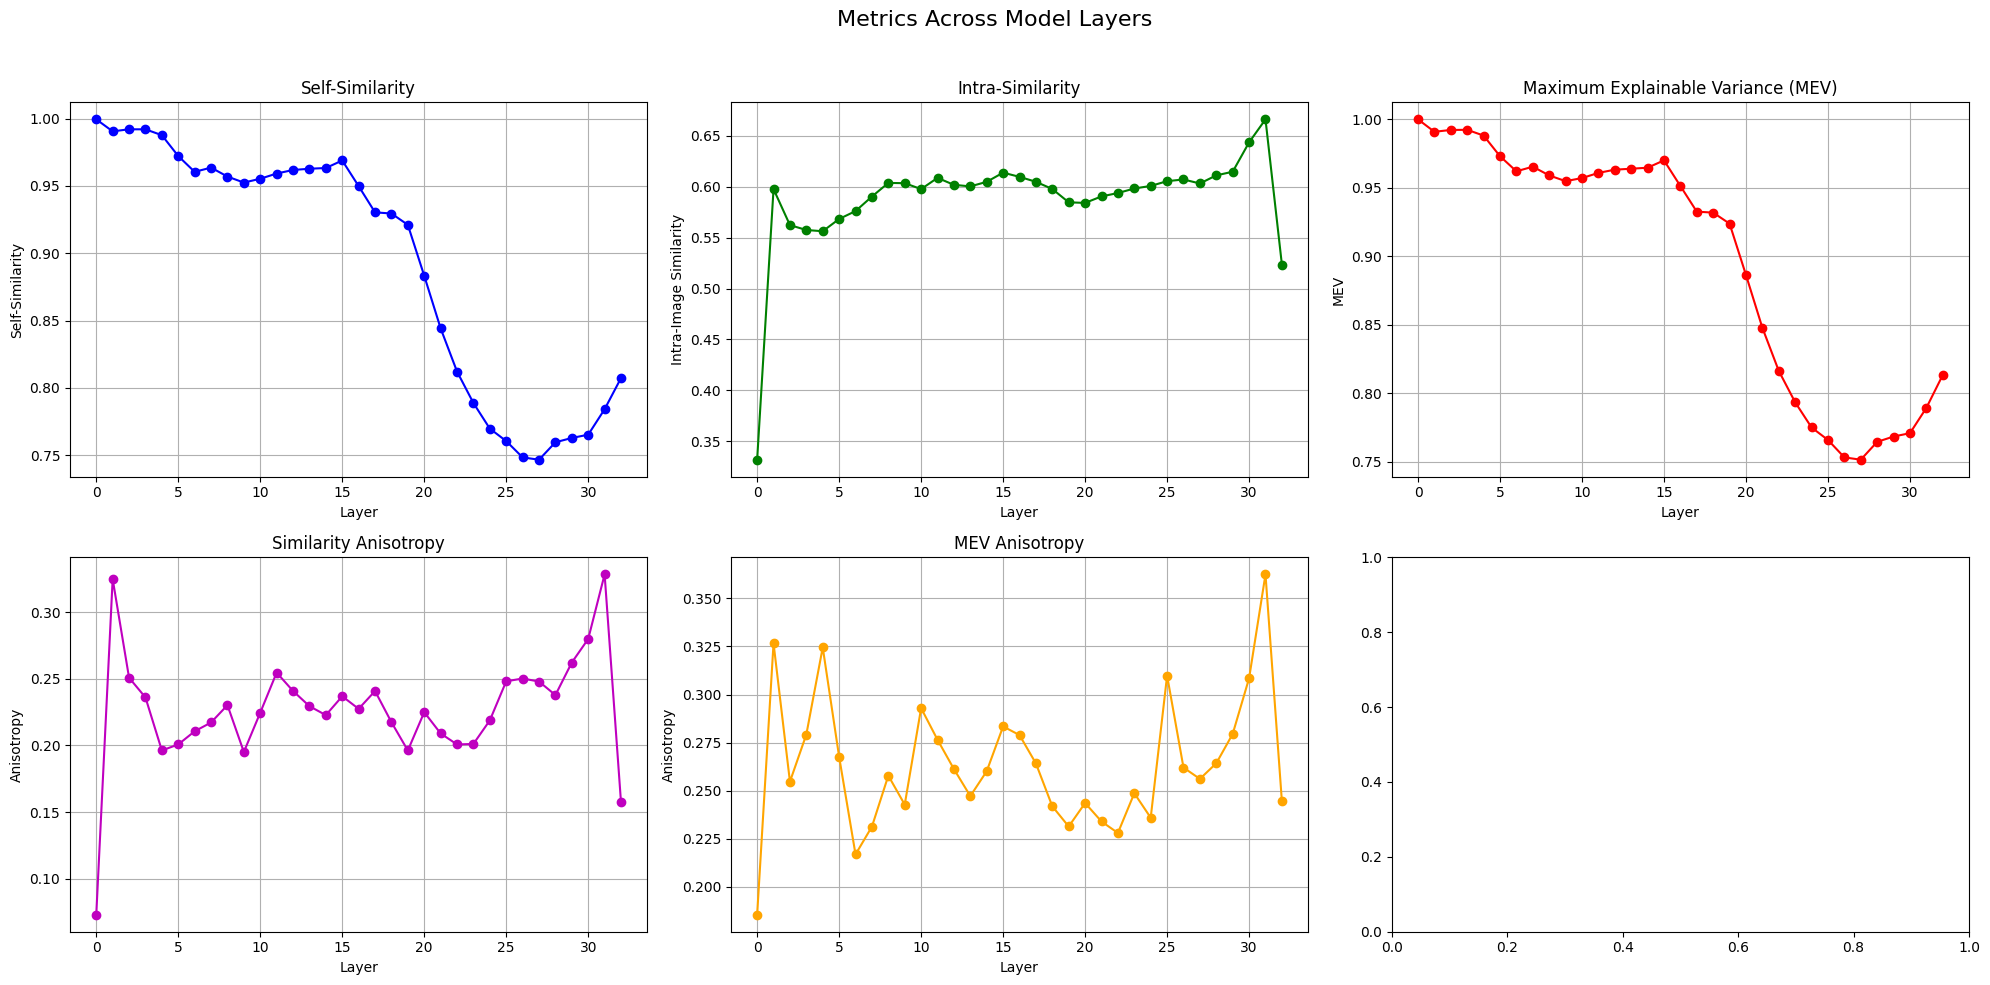

In [52]:
import matplotlib.pyplot as plt

# Plot the metrics for each layer
def plot_metrics(metrics):
    layers = metrics["layer"]
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle('Metrics Across Model Layers', fontsize=16)

    # Plot Self-Similarity
    axs[0, 0].plot(layers, metrics["self_similarity"], marker='o', linestyle='-', color='b')
    axs[0, 0].set_title('Self-Similarity')
    axs[0, 0].set_xlabel('Layer')
    axs[0, 0].set_ylabel('Self-Similarity')
    axs[0, 0].grid(True)

    # Plot Intra-Image Similarity
    axs[0, 1].plot(layers, metrics["intra_similarity"], marker='o', linestyle='-', color='g')
    axs[0, 1].set_title('Intra-Similarity')
    axs[0, 1].set_xlabel('Layer')
    axs[0, 1].set_ylabel('Intra-Image Similarity')
    axs[0, 1].grid(True)

    # Plot Maximum Explainable Variance (MEV)
    axs[0, 2].plot(layers, metrics["mev"], marker='o', linestyle='-', color='r')
    axs[0, 2].set_title('Maximum Explainable Variance (MEV)')
    axs[0, 2].set_xlabel('Layer')
    axs[0, 2].set_ylabel('MEV')
    axs[0, 2].grid(True)

    # Plot Anisotropy
    axs[1, 0].plot(layers, metrics["sim_anisotropy"], marker='o', linestyle='-', color='m')
    axs[1, 0].set_title('Similarity Anisotropy')
    axs[1, 0].set_xlabel('Layer')
    axs[1, 0].set_ylabel('Anisotropy')
    axs[1, 0].grid(True)

    # Plot Anisotropy
    axs[1, 1].plot(layers, metrics["mev_anisotropy"], marker='o', linestyle='-', color='orange')
    axs[1, 1].set_title('MEV Anisotropy')
    axs[1, 1].set_xlabel('Layer')
    axs[1, 1].set_ylabel('Anisotropy')
    axs[1, 1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


plot_metrics(metrics)

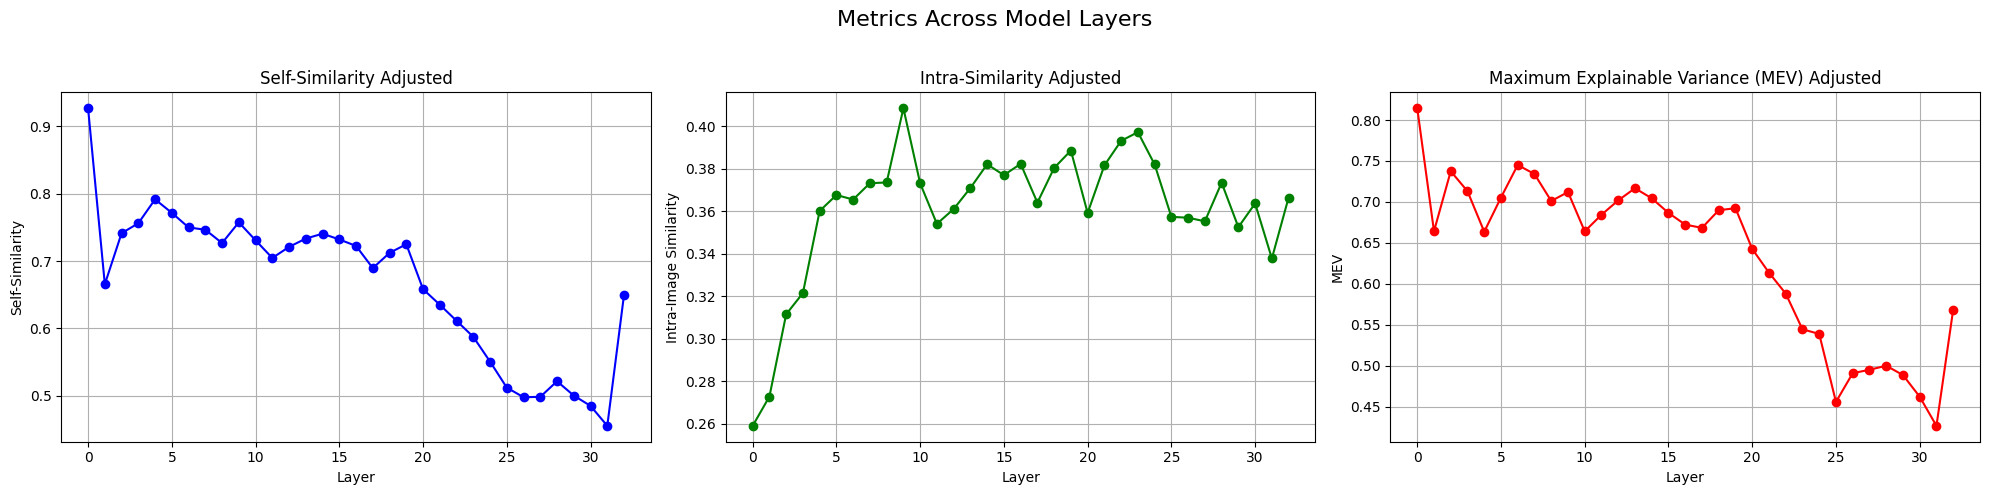

In [53]:
# Plot the metrics for each layer
def plot_adjusted_metrics(metrics):
    layers = metrics["layer"]
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle('Metrics Across Model Layers', fontsize=16)

    # Plot Self-Similarity
    axs[0].plot(layers, np.array(metrics["self_similarity"]) - np.array(metrics["sim_anisotropy"]), marker='o', linestyle='-', color='b')
    axs[0].set_title('Self-Similarity Adjusted')
    axs[0].set_xlabel('Layer')
    axs[0].set_ylabel('Self-Similarity')
    axs[0].grid(True)

    # Plot Intra-Image Similarity
    axs[1].plot(layers, np.array(metrics["intra_similarity"]) - np.array(metrics["sim_anisotropy"]), marker='o', linestyle='-', color='g')
    axs[1].set_title('Intra-Similarity Adjusted')
    axs[1].set_xlabel('Layer')
    axs[1].set_ylabel('Intra-Image Similarity')
    axs[1].grid(True)

    # Plot Maximum Explainable Variance (MEV)
    axs[2].plot(layers, np.array(metrics["mev"]) - np.array(metrics["mev_anisotropy"]), marker='o', linestyle='-', color='r')
    axs[2].set_title('Maximum Explainable Variance (MEV) Adjusted')
    axs[2].set_xlabel('Layer')
    axs[2].set_ylabel('MEV')
    axs[2].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_adjusted_metrics(metrics)